In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [2]:
def get_samples(labels, image, p,sample_size, size=15):
    # np array of shape (sample_size, size, size, 3)
    labels = labels.reshape(image.shape[:2])
    sample = np.zeros((sample_size, size, size, 3), dtype=np.uint8)
    i = 0
    while i < sample_size:
        x, y = np.random.randint(0, labels.shape[0] - size + 1, 2)
        subarray = labels[x:x+size, y:y+size]
        label = np.bincount(subarray.flatten()).argmax()
        if label == p:
            if np.bincount(subarray.flatten())[label] == size * size:
                sample[i] = image[x:x+size, y:y+size]
                i+=1
    return sample

def generate_training_set(labels, image, k, sample_size, size=15):
    training_set_X = np.zeros((k * sample_size, size, size, 3), dtype=np.uint8)
    training_set_y = np.zeros((k * sample_size), dtype=np.uint8)

    for i in range(k):
        training_set_X[i*sample_size:(i+1)*sample_size] = get_samples(labels, image, i, sample_size, size)
        training_set_y[i*sample_size:(i+1)*sample_size] = i
    # Shuffle the training set
    indices = np.arange(training_set_X.shape[0])
    np.random.shuffle(indices)
    training_set_X = training_set_X[indices]
    training_set_y = training_set_y[indices]
    return training_set_X, training_set_y

In [3]:
def generate_2D_mask(masks):
    mask_2D = []
    for i in range(0, len(masks)):
        for j in range(0, len(masks)):
            mask_2D.append(np.outer(masks[i], masks[j]))  
                # mask_2D.append(np.matmul(masks[i].T, masks[j]))

                
    return mask_2D

In [4]:
def apply_mask(img, mask):
    conv_img = cv2.filter2D(img, -1, mask)
    return conv_img

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def apply_sigmoid(conv_img):
    conv_img = sigmoid(conv_img)
    return conv_img

# Energy is sum of squared values of the convolved image
def get_energy(conv_img):
    energy = np.sum(np.square(conv_img))
    return energy

def get_features(img, masks):
    features = np.zeros((len(masks),), dtype=np.float32)
    for i in range(len(masks)):
        mask = masks[i]
        conv_img = apply_mask(img, mask)
        conv_img = apply_sigmoid(conv_img)
        energy = get_energy(conv_img)
        features[i] = energy
    return features

def get_features_from_training_set(train_X, masks):
    features = np.zeros((train_X.shape[0], len(masks)), dtype=np.float32)
    for i in range(train_X.shape[0]):
        img = train_X[i]
        features[i] = get_features(img, masks)
    return features


### Model

In [5]:
data_size = 100
k = 3 
path = 'geo_image2.jpg'
window_size = 15 
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
retvals, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)



In [6]:
dataset = generate_training_set(labels, image, k, data_size, size=window_size)
X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.2, random_state=42)

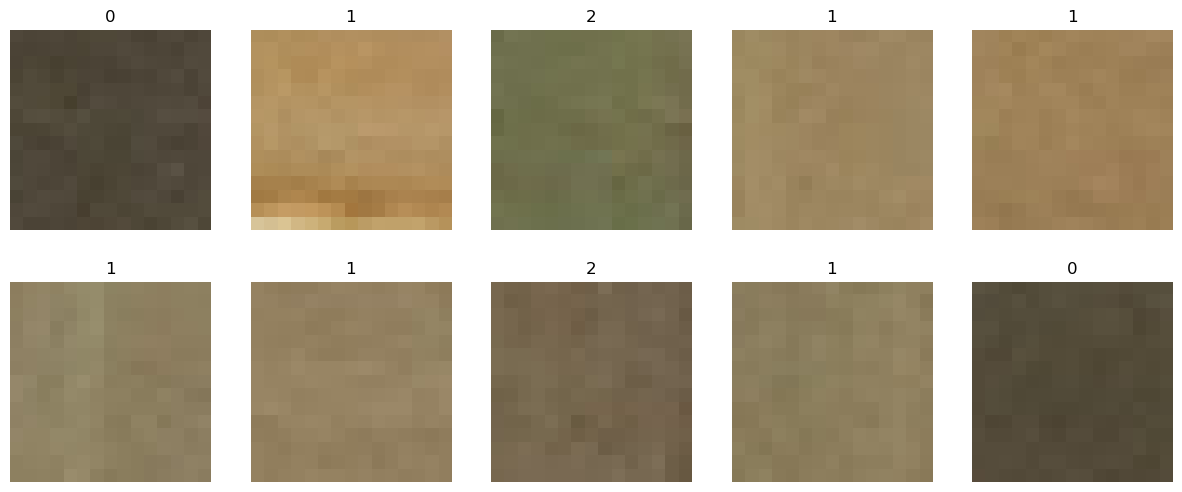

In [7]:
# plot some X_train with their labels
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X_train[i*5+j])
        ax[i, j].set_title(y_train[i*5+j])
        ax[i, j].axis('off')
plt.show()


In [8]:
masks  = np.array([[1, 4, 6, 4, 1],  #L5 level 0 
                [-1, -2, 0, 2, 1],   #E5 level edge 
                [-1, 0, 2, 0, -1],   #S5 level spot
                [-1, 2, 0, -2, 1],   #W5 level wave
                [1, -4, 6, -4, 1]    #R5 level ripple        
])

masks_2D = generate_2D_mask(masks)
X_train_features = get_features_from_training_set(X_train, masks_2D)

X_test_features = get_features_from_training_set(X_test, masks_2D)

C:\Users\bshiv\AppData\Local\Temp\ipykernel_22664\3374188457.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


### Classification Model 

In [9]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1)
clf.fit(X_train_features, y_train)
# Test the modelx
y_pred = clf.predict(X_test_features)
# Print the accuracy
# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_test, y_pred))
# print(y_pred, y_test)

In [10]:
img = cv2.resize(image, (1800, 1800))

In [11]:
# image.shape

In [12]:
sub_size = window_size
segments = np.zeros((int((img.shape[0])/(sub_size))*int((img.shape[0])/(sub_size)) ,   sub_size, sub_size, 3), dtype=np.uint8)

for i in range(0, int(img.shape[0]/sub_size)):
    for j in range(0, int(img.shape[1]/sub_size)):
        segments[i*int(img.shape[1]/sub_size) +j] = img[i*sub_size:i*sub_size+sub_size, j*sub_size:j*sub_size+sub_size]

In [13]:
print(segments.shape)

(14400, 15, 15, 3)


In [14]:
predicted_clusters = np.zeros((segments.shape[0],), dtype=np.uint8)
segmented_features = get_features_from_training_set(segments, masks_2D)
predicted_clusters = clf.predict(segmented_features)
predicted_clusters = predicted_clusters.reshape((int(img.shape[0]/sub_size), int(img.shape[1]/sub_size)))

C:\Users\bshiv\AppData\Local\Temp\ipykernel_22664\3374188457.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


In [15]:
colors = np.random.randint(0, 255, (k, 3))

In [16]:
img_resize = cv2.resize(img, (int(img.shape[0]/sub_size), int(img.shape[1]/sub_size)))

res_color = centers[predicted_clusters.flatten()]
seg_image_color = res_color.reshape((img_resize.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


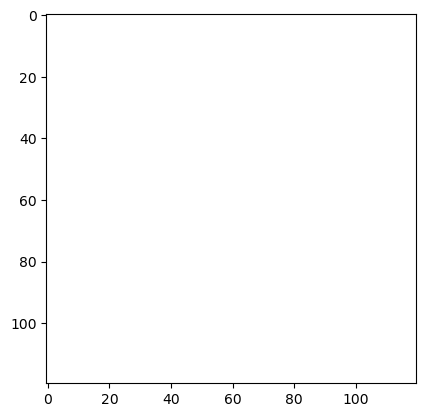

In [17]:
plt.imshow(seg_image_color)
plt.show()

In [18]:
output_folder = "./output"

# output the image into the output folder
cv2.imwrite(output_folder + "/out.jpg", cv2.cvtColor(seg_image_color, cv2.COLOR_RGB2BGR))



True

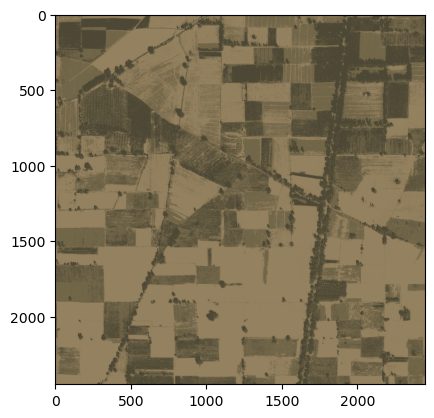

In [70]:
# centers = np.uint8(centers)

# res = centers[labels.flatten()]

# seg_image = res.reshape((image.shape))


# plt.imshow(seg_image)
# plt.show()